In [468]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

In [1571]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim=10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.0
beta_start = beta
beta_end = 5.0
total_step = 500
beta_delta = (beta_end-beta_start)/total_step

save_folder = 'alpha-agg-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

alpha_0 = 10.

mu_c_focus = 0.5

stabilizer_eps = 1.0e-16

In [1572]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [1573]:
def initialize_centers():

    mu_c = mu_c_focus*torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    log_N_k = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c, log_N_k

In [1574]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,log_N_k_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,log_N_k_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [1575]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
log_N_k_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [1576]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,log_N_k_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [1577]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MNIST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,log_N_k_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [1578]:

def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [1579]:
def gauss(mus,logvars,mu_c,logvar_c,log_N_k,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())
            log_pi_k = torch.digamma(alpha_0 + log_N_k.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k.exp().sum(2,keepdim = True))

            gamma_c = ((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp())/(((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = ((((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [1580]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)
    plt.show()


In [1581]:
N_wide = 10
N_sigma =7
def show_generated_samples_c(mu_c,logvar_c):

    for i in range(K_model_cluster):
        sample = torch.empty(latent_dim*(N_wide+1),latent_dim).to(device)
        with torch.no_grad():
            for j in range(latent_dim):
                for k in range(N_wide+1):
                    std_c =torch.zeros(latent_dim).to(device)
                    std_c[j] = (logvar_c_g[0,j,i].exp()).sqrt()
                    sample[j*(N_wide+1)+k,:] = mu_c[0,:,i]+N_sigma*(k-N_wide/2)*std_c/N_wide
            #sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            #sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(latent_dim*(N_wide+1),1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=N_wide+1)
        #生成した６４個のデータを記録しておく

In [1582]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,log_N_k_f):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,784),reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -((((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))+torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True))).exp()).sum(2,keepdim=True)+stabilizer_eps).log()).sum() + ((log_N_k_f.exp())*(torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True)))).sum(2).squeeze() + torch.lgamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2).squeeze()) - (torch.lgamma(alpha_0 + log_N_k_f.exp())).sum(2).squeeze()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [1583]:
def train_c(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, mu, logvar,z = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

#        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {}'.format(
#              epoch,batch_idx*len(data),len(train_loader.dataset),
#                100.*batch_idx/len(train_loader),
#                inv_sm_pi_c_g
#            ))

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c_g,logvar_c_f=logvar_c_g,log_N_k_f=log_N_k_g)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

In [1584]:
def test_c(epoch,mu_c,logvar_c,log_N_k):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,log_N_k_f=log_N_k).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [1585]:
def train_c_epoch(epochs,mu_c,logvar_c,log_N_k):
    for epoch in range(1, epochs +1):
        train_c(epoch)
        test_c(epoch,mu_c,logvar_c,log_N_k)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく


In [1586]:
mu_c_g,logvar_c_g,log_N_k_g

(tensor([[[ 0.2465, -0.1262, -1.1789, -0.1034, -0.0227,  0.2057,  0.8290,
           -0.2366, -1.1050,  0.2461],
          [ 0.2781,  0.1534,  0.4468, -1.0142,  0.9247, -0.4679,  0.1119,
           -2.0733, -1.0302, -1.0688],
          [ 0.1168, -0.6898,  0.1386, -0.2765, -0.3681,  0.6526,  0.2961,
           -0.4677, -0.4074,  0.0442],
          [ 0.3214,  0.0074, -0.1244, -0.5907, -0.6404,  0.0917, -0.0323,
           -0.2437, -0.3598,  0.3577],
          [-0.5349,  0.5533,  0.3793, -1.2099,  0.2402, -0.1234, -0.3023,
            0.5951,  0.4054,  0.4395],
          [ 0.3674,  0.8935,  1.0168,  0.7844,  0.4243,  0.3695, -0.0750,
           -0.2225,  0.6795,  0.1203],
          [-0.1483, -0.0860,  0.1898, -0.1000,  0.9797,  0.5368,  0.1988,
            0.8933,  0.2534, -0.2434],
          [ 0.5548, -1.0933,  0.5005,  0.0156, -0.3791, -0.0662,  1.1631,
            0.0107,  0.0474, -0.1073],
          [-0.0435, -0.4992,  0.9710, -0.2065, -0.1802,  0.1462, -0.0886,
            0.8967,  1

In [1609]:
for i in range(200):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,log_N_k=log_N_k_g)
    scheduler.step()
    scheduler_clustering.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: 130.633604
====> Test set loss: 1.3880
Train Epoch: 1 [0/60000 (0%)]	Loss: 136.273965
====> Test set loss: 1.4111
Train Epoch: 2 [0/60000 (0%)]	Loss: 136.226318
====> Test set loss: 1.4499
Train Epoch: 3 [0/60000 (0%)]	Loss: 137.024063
====> Test set loss: 1.4689
Train Epoch: 4 [0/60000 (0%)]	Loss: 139.165469
====> Test set loss: 1.4263
Train Epoch: 5 [0/60000 (0%)]	Loss: 137.254678
====> Test set loss: 1.4272
Train Epoch: 6 [0/60000 (0%)]	Loss: 137.112764
====> Test set loss: 1.4269
Train Epoch: 7 [0/60000 (0%)]	Loss: 135.081865
====> Test set loss: 1.4435
Train Epoch: 8 [0/60000 (0%)]	Loss: 138.832949
====> Test set loss: 1.4739
Train Epoch: 9 [0/60000 (0%)]	Loss: 130.951719
====> Test set loss: 1.4044
Train Epoch: 10 [0/60000 (0%)]	Loss: 136.631797
====> Test set loss: 1.3284
Train Epoch: 11 [0/60000 (0%)]	Loss: 137.063945
====> Test set loss: 1.4573
Train Epoch: 12 [0/60000 (0%)]	Loss: 134.891445
====> Test set loss: 1.4204
Train Epoch: 13 [0/600

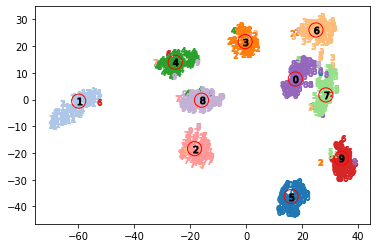

In [1610]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

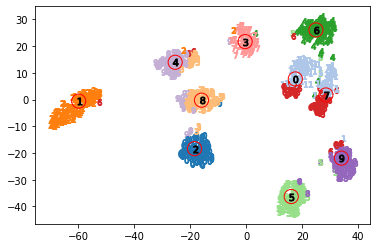

In [1611]:
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

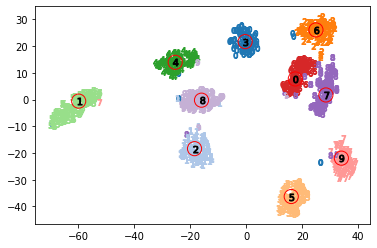

In [1612]:
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

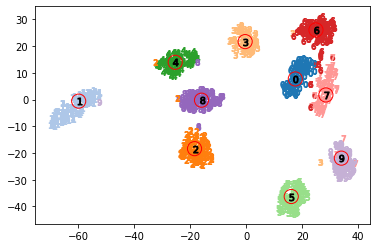

In [1613]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [1614]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [1615]:
#optimizer.param_groups[0]['lr']=0.002,optimizer_clustering.param_groups[0]['lr']=0.002
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0005083731656658001, 0.0005083731656658001, 5.0000000000000036)

In [1616]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [1617]:
correspond_matrix

tensor([[  0.,   0.,   0.,   0.,   0., 103.,   0.,   1.,   0.,   0.],
        [  0., 126.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  77.,   0.,   0.,   1.,   1.,   0.,   0.],
        [  0.,   0.,   2.,   1.,   0.,   0., 101.,   3.,   0.,   0.],
        [  0.,   0.,   0.,   1.,  92.,   0.,   0.,   0.,   3.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   2.,  83.,   0.,   2.],
        [  0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.,   0.,  87.],
        [  0.,   0., 100.,   2.,   0.,   0.,   0.,   0.,   3.,   0.],
        [ 93.,   0.,   0.,   0.,   0.,   0.,   5.,   2.,   1.,   1.],
        [  0.,   1.,   2.,   0.,   1.,   0.,   2.,   0.,  96.,   0.]])

In [1618]:
correspond_matrix.sum()

tensor(1000.)

In [1619]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([ 93., 126., 100.,  77.,  92., 103., 101.,  83.,  96.,  87.]),
indices=tensor([8, 1, 7, 2, 4, 0, 3, 5, 9, 6]))

In [1620]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.9580)

In [1621]:
log_N_k_g.exp().squeeze()

tensor([ 9.0477, 10.8473, 10.3530, 10.5151,  9.6719,  9.8066, 11.2004,  9.1817,
         9.6184,  9.5263], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [1622]:

log_N_k_g.exp().squeeze().sum()

tensor(99.7685, device='cuda:0', grad_fn=<SumBackward0>)

In [1623]:
affinity_mat = torch.zeros(K_model_cluster,K_model_cluster)
affinity_mat

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [1624]:
for i in range(K_model_cluster):
    for j in range(K_model_cluster):
        if i!=j:
#            affinity_mat[i,j]= 1./((mu_c_g[0,:,i]-mu_c_g[0,:,j]).pow(2).sum())
            affinity_mat[i,j]= -(0.5*(((2*math.pi*(logvar_c_g[0,:,i].exp()+logvar_c_g[0,:,j].exp())).log()+(mu_c_g[0,:,i]-mu_c_g[0,:,j]).pow(2)/(logvar_c_g[0,:,i].exp()+logvar_c_g[0,:,j].exp())).sum()))
    for j in range(K_model_cluster):
        if i==j:
            affinity_mat[i,i]= torch.min(affinity_mat)


affinity_mat

tensor([[-18.0456, -11.8396, -14.5316,  -7.4791, -14.8929, -17.3541,  -4.9201,
          -8.0057, -11.0107, -18.0456],
        [-11.8396, -33.5370, -13.5469, -13.4801, -12.4110, -33.5370, -14.6445,
         -23.4739, -16.7593, -19.5245],
        [-14.5316, -13.5469, -42.6745, -17.9692,  -9.8403, -42.6745, -14.7814,
         -16.6701,  -8.6171, -40.8726],
        [ -7.4791, -13.4801, -17.9692, -42.6745,  -9.4552, -14.5946,  -9.1181,
         -13.8982,  -8.1988, -10.9593],
        [-14.8929, -12.4110,  -9.8403,  -9.4552, -42.6745, -27.0784, -18.7466,
         -17.6858,  -5.5232, -14.9660],
        [-17.3541, -33.5370, -42.6745, -14.5946, -27.0784, -42.6745, -11.3861,
          -9.5990, -36.5309,  -9.5929],
        [ -4.9201, -14.6445, -14.7814,  -9.1181, -18.7466, -11.3861, -42.6745,
          -7.0358, -16.7237, -14.5265],
        [ -8.0057, -23.4739, -16.6701, -13.8982, -17.6858,  -9.5990,  -7.0358,
         -42.6745, -19.9344,  -8.4045],
        [-11.0107, -16.7593,  -8.6171,  -8.1988,

In [1625]:
index_mat = torch.arange(K_model_cluster)
index_row = torch.arange(K_model_cluster)

In [1626]:
(i_c,j_c) = np.unravel_index(torch.argmax(affinity_mat),affinity_mat.shape)
for i in range(K_model_cluster):
    if index_row[i]==j_c:
        index_row[i]=i_c
index_mat = torch.cat((index_mat.view(-1,K_model_cluster),index_row.view(1,K_model_cluster)),0)
index_mat,i_c,j_c

(tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 0, 7, 8, 9]]),
 0,
 6)

In [1627]:
affinity_mat[i_c,:]= torch.max(affinity_mat[i_c],affinity_mat[j_c])
#affinity_mat[i_c,:]= (0.5*(affinity_mat[i_c].exp()+affinity_mat[j_c].exp())).log()
affinity_mat[j_c,:]= torch.min(affinity_mat)
affinity_mat[:,j_c]= torch.min(affinity_mat)
affinity_mat[i_c,i_c]= torch.min(affinity_mat)
affinity_mat[:,i_c]= affinity_mat[i_c,:]
affinity_mat

tensor([[-42.6745, -11.8396, -14.5316,  -7.4791, -14.8929, -11.3861, -42.6745,
          -7.0358, -11.0107, -14.5265],
        [-11.8396, -33.5370, -13.5469, -13.4801, -12.4110, -33.5370, -42.6745,
         -23.4739, -16.7593, -19.5245],
        [-14.5316, -13.5469, -42.6745, -17.9692,  -9.8403, -42.6745, -42.6745,
         -16.6701,  -8.6171, -40.8726],
        [ -7.4791, -13.4801, -17.9692, -42.6745,  -9.4552, -14.5946, -42.6745,
         -13.8982,  -8.1988, -10.9593],
        [-14.8929, -12.4110,  -9.8403,  -9.4552, -42.6745, -27.0784, -42.6745,
         -17.6858,  -5.5232, -14.9660],
        [-11.3861, -33.5370, -42.6745, -14.5946, -27.0784, -42.6745, -42.6745,
          -9.5990, -36.5309,  -9.5929],
        [-42.6745, -42.6745, -42.6745, -42.6745, -42.6745, -42.6745, -42.6745,
         -42.6745, -42.6745, -42.6745],
        [ -7.0358, -23.4739, -16.6701, -13.8982, -17.6858,  -9.5990, -42.6745,
         -42.6745, -19.9344,  -8.4045],
        [-11.0107, -16.7593,  -8.6171,  -8.1988,

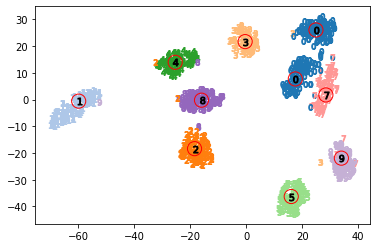

In [1628]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,index_row[torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy()],center_points,index_row)


In [1631]:
torch.save(
    {
        "model_state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "optimizer_clustering" : optimizer_clustering.state_dict(),
        "mu_c_g" : mu_c_g,
        "logvar_c_g" : logvar_c_g,
        "alpha" : alpha_0,
        "beta" : beta,
        "K_model_cluster": K_model_cluster,
        "latent_dim":latent_dim
    },
    "./alpha-agg-results/model/success958.tar"
)